In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
import itertools

# paths
train_path = 'Bur_check/train/color'
valid_path = 'Bur_check/validation/color'
test_path = 'Bur_check/test/color'

# Load
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(90,90), classes=('damaged' , 'good'), batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(90,90), classes=('damaged' , 'good'), batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(90,90), classes=('damaged' , 'good'), batch_size=10)

Using TensorFlow backend.


Found 431 images belonging to 2 classes.
Found 51 images belonging to 2 classes.
Found 42 images belonging to 2 classes.


In [2]:
def plots(ims, figsize=(27,27), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.array:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] !=3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [3]:
imgs, labels = next(valid_batches)

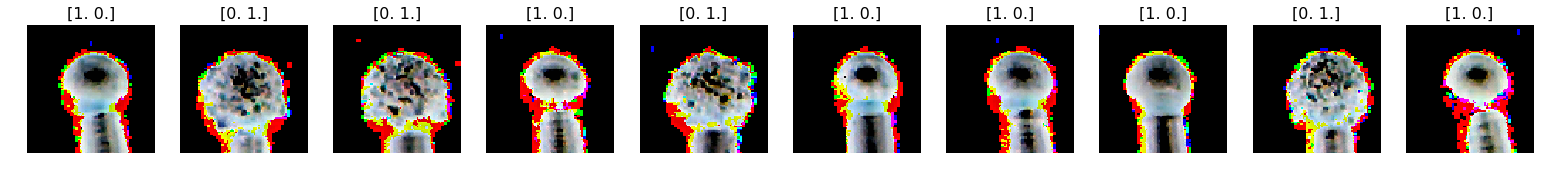

In [4]:
plots(imgs, titles=labels)

## Build and Train CNN

In [6]:

model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(90,90,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, kernel_size=(5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(16, kernel_size=(5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 90, 90, 16)        1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 45, 45, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 16)        12816     
__________

In [9]:
from keras.optimizers import RMSprop
model.compile(RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.fit_generator(train_batches, steps_per_epoch=67, validation_data=valid_batches, validation_steps=4, epochs=6, verbose=2)

Epoch 1/6
 - 114s - loss: 5.0670 - acc: 0.6330 - val_loss: 0.1455 - val_acc: 0.9250
Epoch 2/6
 - 105s - loss: 0.1417 - acc: 0.9688 - val_loss: 0.0109 - val_acc: 1.0000
Epoch 3/6
 - 101s - loss: 0.0834 - acc: 0.9910 - val_loss: 0.1331 - val_acc: 0.9500
Epoch 4/6
 - 127s - loss: 0.0757 - acc: 0.9925 - val_loss: 0.0126 - val_acc: 1.0000
Epoch 5/6
 - 116s - loss: 0.0556 - acc: 0.9940 - val_loss: 0.0111 - val_acc: 1.0000
Epoch 6/6
 - 101s - loss: 0.0490 - acc: 0.9985 - val_loss: 0.0147 - val_acc: 1.0000


## Predict

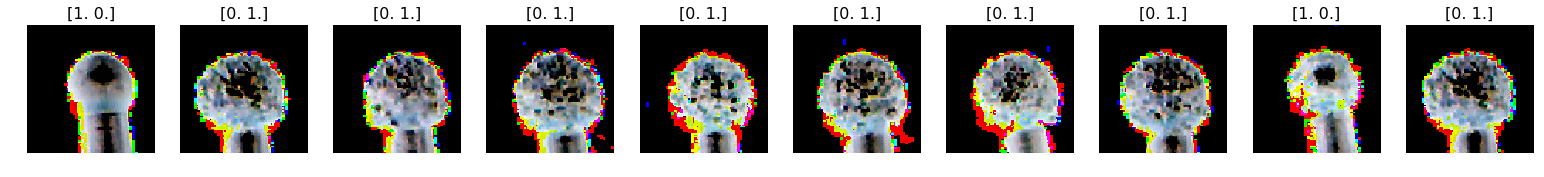

In [67]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [68]:
test_labels = test_labels[:,0]
test_labels

array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [69]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [38]:
predictions = model.predict(test_imgs, verbose=0)

In [70]:
predictions = predictions.round()

In [71]:
predictions

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [49]:
score = model.evaluate_generator(test_batches)
print("accuracy: ", score[1])

('accuracy: ', 0.9523809410276867)


In [72]:
cm = confusion_matrix(test_labels, predictions[:,0])

In [73]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color='white' if cm[i ,j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

Confusion matrix, without normalization
[[8 0]
 [0 2]]


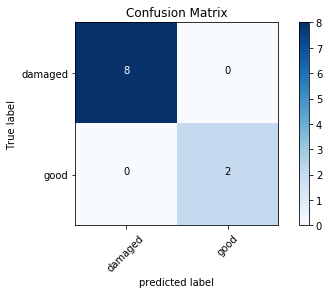

In [74]:
cm_plot_labels = ['damaged', 'good']
plot_confusion_matrix(cm, cm_plot_labels, title= 'Confusion Matrix')

In [21]:
score = model.evaluate_generator(train_batches)
print("accuracy: ", score[1])

('accuracy: ', 1.0)


In [22]:
score = model.evaluate_generator(valid_batches)
print("accuracy: ", score[1])

('accuracy: ', 0.980392152187871)


In [75]:
# serialize model to JSON
model_json = model.to_json()
with open("Bur_model_aap_4.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Bur_model_aap_4.h5")
print("Saved model to disk")

Saved model to disk
